## Events Analysis

This notebook looks at changes around major U.S. events: 9/11, the 2008 Financial Crisis, and the 2016 election.

### Import packages and load data

In [1]:
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import nltk
import seaborn as sns

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

from ast import literal_eval
import source.helper_functions as helper


In [2]:
# load corpus
file = '../tal-scrape/total_trans_normalized.csv'
tal_df = pd.read_csv(file, converters = helper.converters)

In [3]:
tal_df.head()

,ep_num,ep_title,year,url,act_name,text,tokenized_sents,no_lemma_normalized_sents,normalized_sents,tokenized_text,normalized_tokens,no_lemma_normalized_tokens
0,1,New Beginnings,1995,https://www.thisamericanlife.org/1/transcript,Act Four: Act Four,This is Your Radio Playhouse. I'm Ira Glass. O...,"[[This, is, Your, Radio, Playhouse], [I, 'm, I...","[[radio, playhouse], [m, ira, glass], [ok, rig...","[[radio, playhouse], [be, ira, glass], [okay, ...","[This, is, Your, Radio, Playhouse, I, 'm, Ira,...","[radio, playhouse, be, ira, glass, okay, right...","[radio, playhouse, m, ira, glass, ok, right, r..."
1,1,New Beginnings,1995,https://www.thisamericanlife.org/1/transcript,Act Three: Act Three,"Well, next on our little playhouse stage, we h...","[[Well, next, on, our, little, playhouse, stag...","[[little, playhouse, stage, mr, lawrence, steg...","[[little, playhouse, stage, mr, lawrence, steg...","[Well, next, on, our, little, playhouse, stage...","[little, playhouse, stage, mr, lawrence, stege...","[little, playhouse, stage, mr, lawrence, stege..."
2,1,New Beginnings,1995,https://www.thisamericanlife.org/1/transcript,Act Two: Act Two,"Good morning. Glass, Jacobson & Associates.Hey...","[[Good, morning], [Glass, Jacobson, Associates...","[[good, morning], [glass, jacobson, associates...","[[good, morning], [glass, jacobson, associate]...","[Good, morning, Glass, Jacobson, Associates, H...","[good, morning, glass, jacobson, associate, he...","[good, morning, glass, jacobson, associates, h..."
3,1,New Beginnings,1995,https://www.thisamericanlife.org/1/transcript,Act One: Act One,"All right, Your Radio Playhouse. All right. I'...","[[All, right, Your, Radio, Playhouse], [All, r...","[[right, radio, playhouse], [right], [m, makin...","[[right, radio, playhouse], [right], [be, make...","[All, right, Your, Radio, Playhouse, All, righ...","[right, radio, playhouse, right, be, make, eye...","[right, radio, playhouse, right, m, making, ey..."
4,1,New Beginnings,1995,https://www.thisamericanlife.org/1/transcript,Prologue,"Joe Franklin?I'm ready.It's Ira Glass here.Oh,...","[[Joe, Franklin?I'm, ready], [It, 's, Ira, Gla...","[[joe, franklin?i'm, ready], [ira, glass], [oh...","[[joe, franklin?i'm, ready], [ira, glass], [oh...","[Joe, Franklin?I'm, ready, It, 's, Ira, Glass,...","[joe, franklin?i'm, ready, ira, glass, oh, emc...","[joe, franklin?i'm, ready, ira, glass, oh, emc..."


## Event 1: 9/11

Words of interest:

In [12]:
# words of interest for this event
word1 = ['iraq', 'iraqi', 'iraqis', 'afghanistan', 'qaeda', 'weapon', 'weapons', 'muslim', 'muslims', 
         'terrorist', 'terrorism', 'terror', 'panic', 'war', 'hate', 'soldier', 'soldiers', 
         'ally', 'allies', 'security', 'secure']
word2 = ['love', 'america', 'american', 'country', 'safe', 'family', 'home']

In [4]:
# load 1998 to 2003 dataframe
# it has POS_sents saved to it because that takes awhile to run and is used in most common adjectives
tal_df = pd.read_csv('trans_total_pos_98-03.csv', converters = {'tokenized_sents': literal_eval,'no_lemma_normalized_sents': literal_eval,
                'normalized_sents':literal_eval,'tokenized_text':literal_eval,
                'normalized_tokens':literal_eval,'no_lemma_normalized_tokens':literal_eval, 'POS_sents': literal_eval})

#### First, I will examine collocations.

I will focus on comparing collocations of certain words in each of the three years before 2001 (i.e. 1998,1999,2000). Then I will look at colocations in the year of the event and the two years after (2001,2002,2003)

In [5]:
# prep text
df98 = tal_df[tal_df.year==1998]
df99 = tal_df[tal_df.year==1999]
df00 = tal_df[tal_df.year==2000]
df01 = tal_df[tal_df.year==2001]
df02 = tal_df[tal_df.year==2002]
df03 = tal_df[tal_df.year==2003]

In [374]:
def get_text_collocation(df):
    return nltk.Text(df.no_lemma_normalized_tokens.sum())

def get_concordance(text, word):
    index = nltk.text.ConcordanceIndex(text)
    return index.find_concordance(word)

def get_context(text, words):
    index = nltk.text.ContextIndex(text)
    return index.common_contexts(words)

def get_count(text,word):
    return text.count(word)

def plot_count(full_df, years, word):
    # counts
    years = sorted(years)
    counts = []
    for y in years:
        tmp = full_df[full_df.year==y]
        text = get_text_collocation(tmp)
        c = get_count(text,word)
        counts.append(c)
    sns.lineplot(x=years, y=counts)
    plt.title('Frequency of {} in TAL'.format(word))
    plt.show()

def print_collocation(df, wordlist, concordance=False, context=True):
    text = get_text_collocation(df)
    
    for w in wordlist:
        print('Word: {}'.format(w))
        if concordance:
            print('Concordance: ')
            get_concordance(text, w)
            print()
        if context:
            print('Common context: ')
            get_context(text, [w])
        print()
        print()
        
def plot_dispersion(df,wordlist):
    text = get_text_collocation(df)
    sns.reset_orig() #Seaborn messes with this plot, disabling it
    text.dispersion_plot(wordlist)
    sns.set() #Re-enabling seaborn

In [486]:
def agg_contexts(dfs,years,wordlist):
    final = []
    for df in dfs:
        text = get_text_collocation(df)
        tmp = {}
        for w in wordlist:
            x = list(get_context(text, [w]).keys())
            tmp[w] = x
        final.append(tmp)
        
    new = pd.DataFrame(final)
    new['year'] = years
    return new

In [121]:
def make_agg_verb_dict(verb, dfs):
    verb_list = []
    for df in dfs:
        verb_list.append(make_verb_dict(verb,df))
    return verb_list

In [126]:
df98.dtypes

ep_num                         int64
ep_title                      object
year                           int64
url                           object
act_name                      object
text                          object
tokenized_sents               object
no_lemma_normalized_sents     object
normalized_sents              object
tokenized_text                object
normalized_tokens             object
no_lemma_normalized_tokens    object
dtype: object

In [140]:
def make_verb_dict(verb, df):
    verb_dict = {}
    nlp = spacy.load("en")
    for index, row in df.iterrows():
        year = str(row['year'])
        if year not in verb_dict.keys():
            verb_dict[year] = ([],[])
        text = ' '.join(row['tokenized_text'])
        doc = nlp(text)
        for chunk in doc.noun_chunks:
            subject = 0
            object_ = 0
            # if the verb or the root of the sentence is the word
            if chunk.root.head.text == verb:
                # we find the subjects and objects around the word,
                # and if it does exist, add it to the tuple
                if chunk.root.dep_ == 'nsubj':
                    subject = chunk.root.text
                if chunk.root.dep_ == 'dobj':
                    object_ = chunk.root.text
                if subject is not 0:
                    verb_dict[year][0].append(subject)
                if object_ is not 0:
                    verb_dict[year][1].append(object_)
    return verb_dict

In [6]:
grouped = tal_df[(tal_df.year==1998) | (tal_df.year==1999) | (tal_df.year==2000)]

In [8]:
grouped2 = tal_df[(tal_df.year==2001) | (tal_df.year==2002) | (tal_df.year==2003)]

## Subject/object for verbs

In [7]:
# for 1998-2000 - takes awhile to run
x = helper.make_verb_dict('hate', grouped)
x

{'1998': (['they',
   'people',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'people',
   'she',
   'I',
   'I',
   'they',
   'We',
   'I',
   'I',
   'I',
   'I',
   'I',
   'you',
   'I',
   'I',
   'I',
   'I',
   'I'],
  ['What',
   'past',
   'room',
   'guts',
   'brothers',
   'him',
   'tits',
   'word',
   'Carrey',
   'him',
   'falls',
   'them',
   'place',
   'life',
   'column',
   'you',
   'you',
   'you',
   'you',
   'Timberlands']),
 '1999': (['you', 'I', 'they', 'you', 'I'], ['act', 'him']),
 '2000': (['They',
   'I',
   'brother',
   'I',
   'brother',
   'I',
   'I',
   'I',
   'who',
   'everyone',
   'They',
   'she',
   'they',
   'I',
   'I',
   'I',
   'I',
   'who',
   'I',
   'I',
   'I',
   'me'],
  ['you',
   'brother',
   'myself',
   'brother',
   'myself',
   'it',
   'club',
   'me',
   'you?I',
   'Bradley',
   'you',
   'people',
   'them',
   'them',
   'guts',
   'him',
   'him',
   'couple',
   'them',
   't

In [10]:
# 2001-2003 - takes awhile to run
z=helper.make_verb_dict('hate', grouped2)

In [16]:
z

{'2001': (['you',
   'I',
   'I',
   'he',
   'who',
   'we',
   'I',
   'I',
   'I',
   'I',
   'people',
   'people',
   'I',
   'you',
   'I',
   'I',
   'You',
   'I',
   'people',
   'I'],
  ['person',
   'him',
   'music',
   'it',
   'for--',
   'facts',
   'States',
   'olives',
   'them',
   'us',
   'it']),
 '2002': (['I',
   'who',
   'people',
   'I',
   'I',
   'I',
   'you',
   'we',
   'I',
   'physicists',
   'it',
   'I',
   'you',
   'I',
   'I',
   'I',
   'they',
   'you',
   'I',
   'people',
   'I',
   'you',
   'you',
   'He',
   'him',
   'you',
   'you',
   'you',
   'I',
   'I',
   'I',
   'I',
   'Americans',
   'Arabs'],
  ['you',
   'you',
   'you',
   'you',
   'torpedoes',
   'parents',
   'it',
   'pepper',
   'What',
   'fact',
   'it',
   'us',
   'Jews',
   'them',
   'people',
   'you',
   'men',
   'them',
   'it',
   'it',
   'it',
   'What',
   'house',
   'yourself',
   'it',
   'it',
   'way',
   'everything',
   'Islam',
   'him',
   'him']),
 

## Get common_contexts across years for a particular words

In [13]:
# takes awhile to run
y = helper.agg_contexts([df98,df99,df00,df01,df02,df03], [1998,1999,2000,2001,2002,2003], word2)

In [488]:
y.to_csv('9_11_home_contexts.csv',index=False)

## Get frequency counts across years

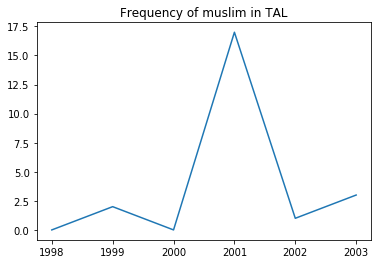

In [15]:
helper.plot_count(tal_df,[1998,1999,2000,2001,2002,2003],'muslim')

## Most common adjectives

In [20]:
helper.most_common_adj(df98, 'war')

{'civil': 1, 'big': 1, 'anti': 1}

In [21]:
helper.most_common_adj(df99, 'war')

{'civil': 1, 'religious': 1, 'anti': 1}

In [22]:
helper.most_common_adj(df00, 'war')

{'active': 1}

In [23]:
helper.most_common_adj(df01, 'war')

{'civil': 2,
 'turf': 1,
 'other': 1,
 'mock': 1,
 'massive': 1,
 'coming': 1,
 'bloody': 1,
 'Israeli': 1,
 'American': 1,
 'current': 1,
 'unpopular': 1,
 'holy': 1}

In [24]:
helper.most_common_adj(df02, 'war')

{'overall': 1, 'nuclear': 1, 'successful': 1, 'likely': 1, 'narrow': 1}

In [25]:
helper.most_common_adj(df03, 'war')

{'previous': 1,
 'current': 1,
 'last': 1,
 'different': 1,
 'other': 1,
 'splendid': 1,
 'new': 1,
 'possible': 1,
 'first': 1,
 'bloody': 1,
 'preventive': 1,
 'anti': 3,
 'civil': 1,
 'political': 1,
 'little': 1,
 'holy': 2}

In [111]:
import spacy
nlp = spacy.load("en")

In [114]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    nlp = spacy.load("en")
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [129]:
def most_common_adj(df, word):
    if 'POS_sents' not in df.columns:
        df['POS_sents'] = df.apply(lambda x: tag_sents_pos(x['tokenized_sents']), axis=1)
    NTarget = 'JJ'
    NResults = {}
    for entry in df['POS_sents']:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind1,ent2.lower())==(NTarget,word):
                    if ent1 in NResults.keys():
                        NResults[ent1] +=1
                    else:
                        NResults[ent1] =1
                else:
                    continue
    return NResults

## Individual years 

Which should we focus on? Definitely see some expected trends that are quantified here. (Muslim doesn't even really show up until 2001). 

### 1998

In [73]:
helper.print_collocation(df98, word1)

Word: iraq
Common context: 
('The following word(s) were not found:', 'iraq')


Word: iraqi
Common context: 
('The following word(s) were not found:', 'iraqi')


Word: iraqis
Common context: 
('The following word(s) were not found:', 'iraqis')


Word: afghanistan
Common context: 
landing_called


Word: qaeda
Common context: 
('The following word(s) were not found:', 'qaeda')


Word: weapon
Common context: 
head_small nuclear_deposited poked_anders


Word: weapons
Common context: 
('The following word(s) were not found:', 'weapons')


Word: muslim
Common context: 
('The following word(s) were not found:', 'muslim')


Word: muslims
Common context: 
('The following word(s) were not found:', 'muslims')


Word: terrorist
Common context: 
('The following word(s) were not found:', 'terrorist')


Word: terrorism
Common context: 
('The following word(s) were not found:', 'terrorism')


Word: terror
Common context: 
represented_life got_falls got_water cry_father trilogy_gets
tears_loss tv_news


In [74]:
helper.print_collocation(df98, word2)

Word: home
Common context: 
living_mom songs_actually went_exercise come_throw come_business
coming_hanging come_kind came_slept driving_blue rode_seat drove_blue
work_spotting bus_courage come_honey bringing_second come_smoke
comes_day time_got went_today come_listen


Word: family
Common context: 
red?my_understand right_love typical_thing fat_scale parents_phone
conferences_going taking_soon mexican_married outcast_m oldest_find
wants_like vacations_unhappy relationship_suffered cast_needed
scratch_job margy_families sex_kind sex_little came_laura sister_dish


Word: safe
Common context: 
little_holding drive_bring rules_puts fairly_rockets stay_possible
volunteer_place pray_trip ensure_passage decline_happy felt_letting
feel_m concern_yeah verbalize_let unusually_bubble living_little
thoroughly_unfortunately cider_said saying_drink twice_hazardous
produce_cider


Word: country
Common context: 
leaving_brings washington_melamid landscape_want want_holland
beautiful_museum opposite_b

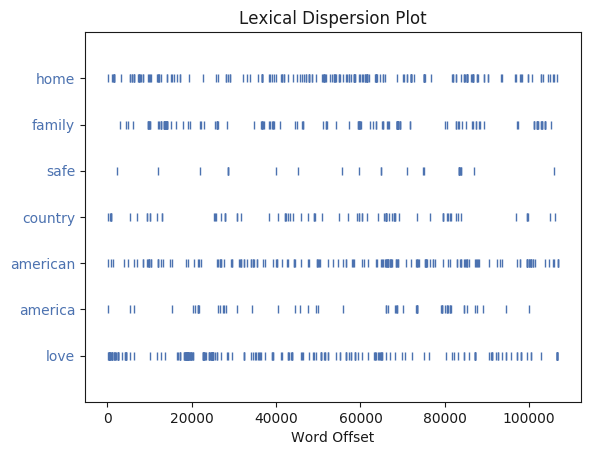

In [76]:
helper.plot_dispersion(text, word2)

In [415]:
most_common_adj(df98, 'country')

{'beautiful': 1,
 'old': 2,
 'good': 1,
 'bad': 2,
 'Good': 1,
 'own': 1,
 'open': 1,
 'particular': 1}

### 1999

Word: iraq
Common context: 
('The following word(s) were not found:', 'iraq')


Word: iraqi
Common context: 
('The following word(s) were not found:', 'iraqi')


Word: iraqis
Common context: 
('The following word(s) were not found:', 'iraqis')


Word: afghanistan
Common context: 
refugee_today


Word: qaeda
Common context: 
('The following word(s) were not found:', 'qaeda')


Word: weapon
Common context: 
coming_thought


Word: weapons
Common context: 
main_alcohol thing_phone believe_involved


Word: muslim
Common context: 
jealously_authorities grown_country


Word: muslims
Common context: 
sites_believe


Word: terrorist
Common context: 
albino_act like_bases


Word: terrorism
Common context: 
treason_framed


Word: terror
Common context: 
dad_alive signs_try release_torial element_times live_father
event_mounted apartment_targeted family_horror grandeur_fact


Word: panic
Common context: 
private_found bit_factor god_starting primary_having secondary_knowing
tertiary_realizing feel

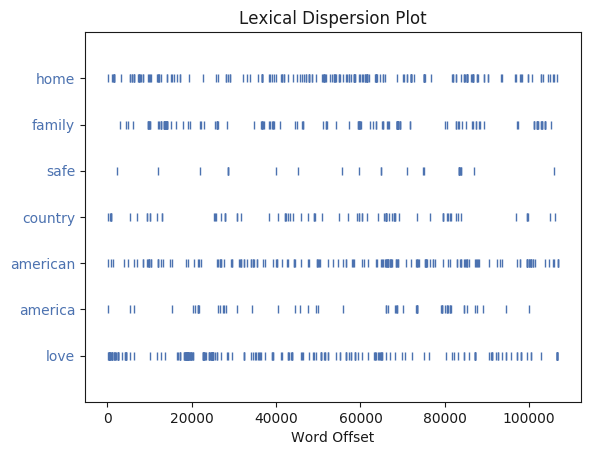

In [78]:
helper.print_collocation(df99, word1)

helper.print_collocation(df99, word2)

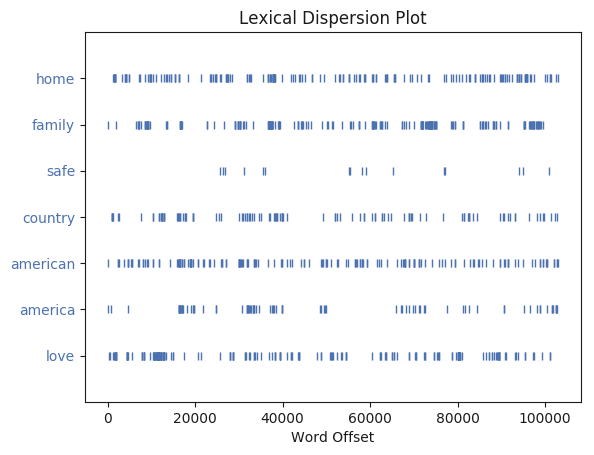

In [387]:
plot_dispersion(df99,word2)

In [414]:
most_common_adj(df99, 'country')

{'fair': 1,
 'entire': 1,
 'small': 3,
 'developed': 1,
 'poor': 1,
 'free': 1,
 'African': 1,
 'rich': 1,
 'advanced': 1,
 'civilized': 1,
 'black': 1,
 'fine': 1,
 'same': 1,
 'crinkly': 1,
 'Muslim': 1,
 'whole': 1}

### 2000

Word: iraq
Common context: 
('The following word(s) were not found:', 'iraq')


Word: iraqi
Common context: 
('The following word(s) were not found:', 'iraqi')


Word: iraqis
Common context: 
('The following word(s) were not found:', 'iraqis')


Word: afghanistan
Common context: 
('The following word(s) were not found:', 'afghanistan')


Word: qaeda
Common context: 
('The following word(s) were not found:', 'qaeda')


Word: weapon
Common context: 
older_ai


Word: weapons
Common context: 
('The following word(s) were not found:', 'weapons')


Word: muslim
Common context: 
('The following word(s) were not found:', 'muslim')


Word: muslims
Common context: 
('The following word(s) were not found:', 'muslims')


Word: terrorist
Common context: 
('The following word(s) were not found:', 'terrorist')


Word: terrorism
Common context: 
('The following word(s) were not found:', 'terrorism')


Word: terror
Common context: 
striking_edith ground_lightning mob_mob fear_firsthand


Word: panic
Co

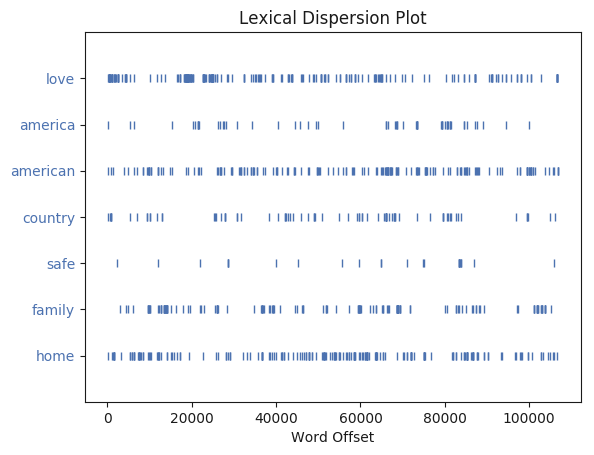

In [79]:
helper.print_collocation(df00, word1)

helper.print_collocation(df00, word2)

helper.plot_dispersion(text, word2)

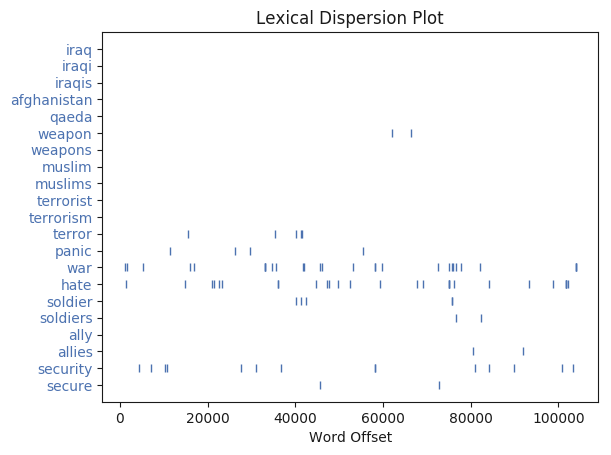

In [93]:
helper.plot_dispersion(df00,word1)

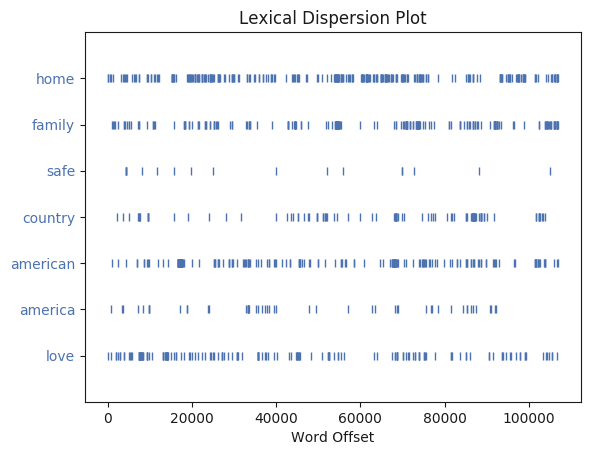

In [383]:
plot_dispersion(df00, word2)

In [413]:
most_common_adj(df00, 'country')

{'foreign': 2, 'new': 1, 'enough': 1, 'white': 1, 'exclusive': 1}

### 2001

In [95]:
helper.print_collocation(df01, word1)

helper.print_collocation(df01, word2)

helper.plot_dispersion(text, word2)

Word: secure
Common context: 
flight--_doors cicero_chicago head_folks


Word: security
Common context: 
like_feel information_person annoying_floodlights inside_alarm
response_grab dogs_proper social_rest heavy_line national_archive
nations_council


Word: allies
Common context: 
bush_showed fall_acknowledged surrender_changed history_routinely


Word: ally
Common context: 
wear_sheedy strong_west


Word: soldiers
Common context: 
twin_command killed_says killed_fired whim_like ordinary_giving
battle_sides faces_standing pakistani_un american_killed
american_involved young_trained american_allowed trained_world
american_certainly israeli_shooting government_suddenly lots_found
visit_stationed tank_gather numbers_messages


Word: soldier
Common context: 
affection_lap lap_lap lap_come come_quickly japanese_viking dead_ruins
israeli_checkpoint


Word: hate
Common context: 
supreme_supreme want_says heaven_person know_rochester his--_this--
bosses_hate hate_found things_horrifying julie_

AttributeError: 'Text' object has no attribute 'no_lemma_normalized_tokens'

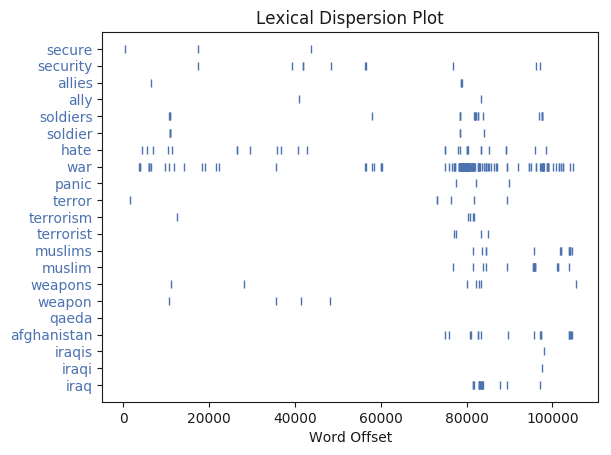

In [88]:
helper.plot_dispersion(df01,word1)

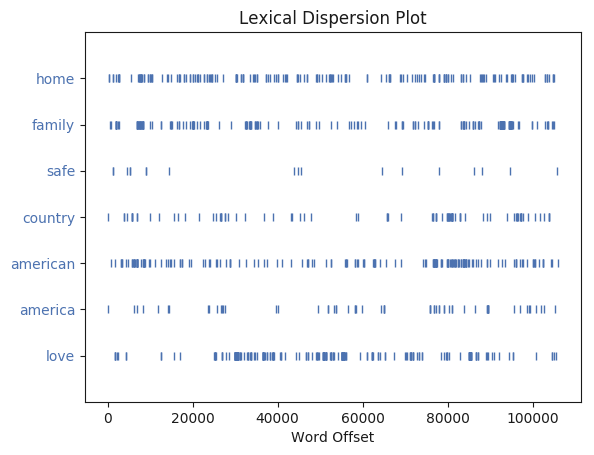

In [379]:
plot_dispersion(df01,word2)

In [411]:
most_common_adj(df01,'home')

{'other': 1,
 'sweet': 2,
 'only': 1,
 'first': 1,
 'foster': 1,
 'new': 1,
 'own': 1,
 'mobile': 2}

### 2002

Word: iraq
Common context: 
iran_pa deployed_afghanistan danger_posed war_priority war_yes
issue_ira war_public war_justified going_ways war_likely war_ve
point_links qaeda_breaking war_actually focus_expense war_think
comes_realists believe_weapons iran_war helping_weak


Word: iraqi
Common context: 
happening_forces processed_prisoners hear_soldier overthrow_regime
communicated_foreign heeded_officials oil_oil hear_perspectives
hundreds_refugees lot_run years_army power_army america_army--
defend_soldiers life_army buy_poor 18-ish_guys different_neighborhood
day_embassy poor_neighborhood


Word: iraqis
Common context: 
threat_heeded speeches_ve including_close population_come filled_cars
look_look ask_think tells_knows things_usually person_desperate
turn_invite talking_hearing


Word: afghanistan
Common context: 
fighting_today troops_alex operations_incredibly bomb_minute iraq_war
missions_monitoring like_look fly_fly win_find


Word: qaeda
Common context: 
al_nautical al_iraq al_d

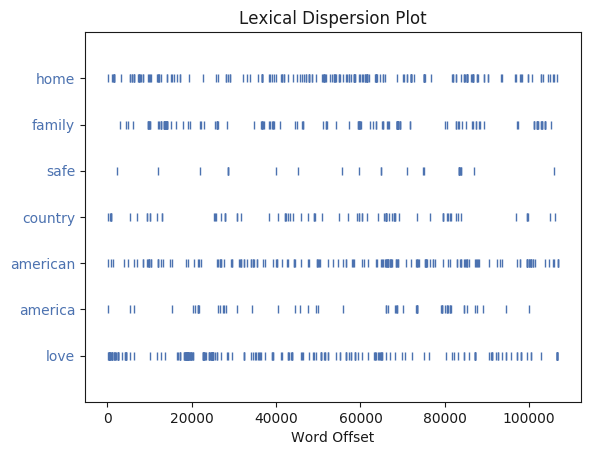

In [82]:
helper.print_collocation(df02, word1)

helper.print_collocation(df02, word2)

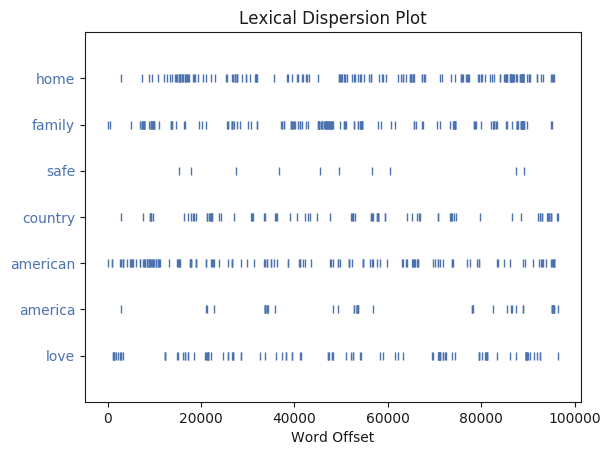

In [381]:
plot_dispersion(df02, word2)

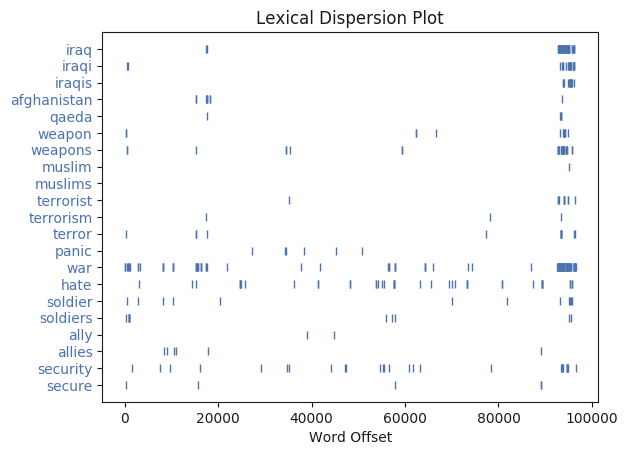

In [89]:
helper.plot_dispersion(df02,word1)

In [409]:
most_common_adj(df02, 'home')

{'affectionate': 1,
 'suburban': 2,
 'wonderful': 1,
 'future': 1,
 'big': 1,
 'good': 1,
 'actual': 1,
 'different': 1,
 'other': 2,
 'old': 1}

In [410]:
most_common_adj(df02, 'country')

{'huge': 2,
 'beautiful': 1,
 'other': 2,
 'cold': 1,
 'Amish': 1,
 'big': 1,
 'boring': 1,
 'Palestinian': 1,
 'democratic': 1,
 'Arab': 1,
 'old': 3,
 'large': 1,
 'nice': 1}

### 2003

Word: iraq
Common context: 
fly_lands kuwait_iraqi transjordan_invade happen_maybe reason_middle
people_pakistan baghdad_joe war_europe shift_placed iran_war?yes
range_chemical government_right campaign_right happened_afghanistan
liberate_saddam people_doubted going_probably far_story war_largest
war_long


Word: iraqi
Common context: 
men_soldiers gas_kurds wait_army dropped_forces iraq_air bleep_hear
rpgs_soldiers number_deaths operation_freedom heard_soldiers
spoke_named smiling_army kennedy_army burning_currency $_photo
lot_newspapers young_girl mind_suffering solidarity_people
smuggled_named


Word: iraqis
Common context: 
iran_experts wonder_preparing annihilate_shirts chance_drop
near_competent platoon_appears surrendering_remains shoot_spend
dead_surrounding crushing_sleep let_seventh find_persuade freedom_want
gap_americans gotten_agency cpa_know want_poor pages_general
general_know group_speak


Word: afghanistan
Common context: 
pakistan_according captured_padilla battle_ene

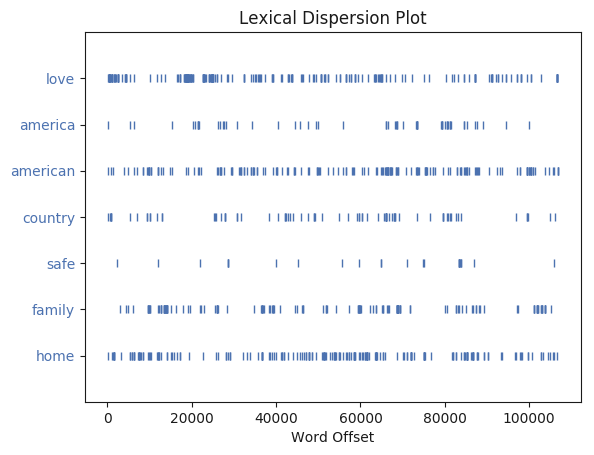

In [83]:
helper.print_collocation(df03, word1)

helper.print_collocation(df03, word2)

helper.plot_dispersion(text, word2)

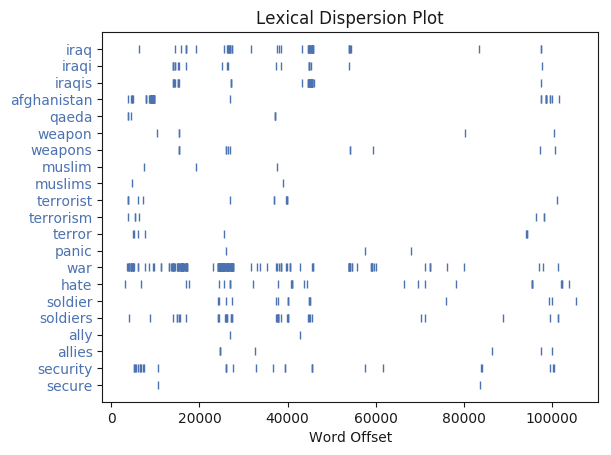

In [378]:
plot_dispersion(df03,word1)

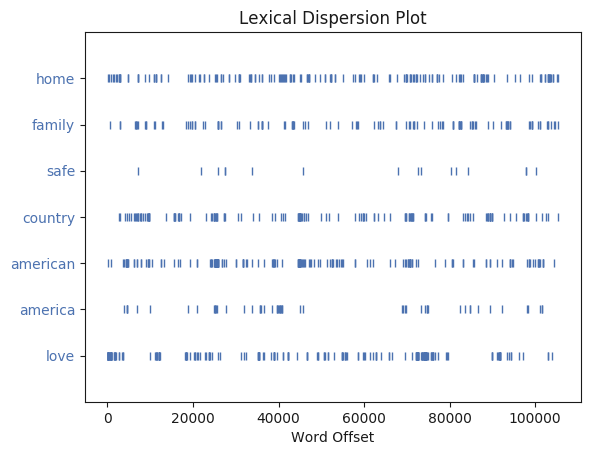

In [385]:
plot_dispersion(df03, word2)

In [408]:
most_common_adj(df03, 'home')

{'mobile': 3, 'own': 1, 'real': 1, 'new': 1}

## Aggregate over the years

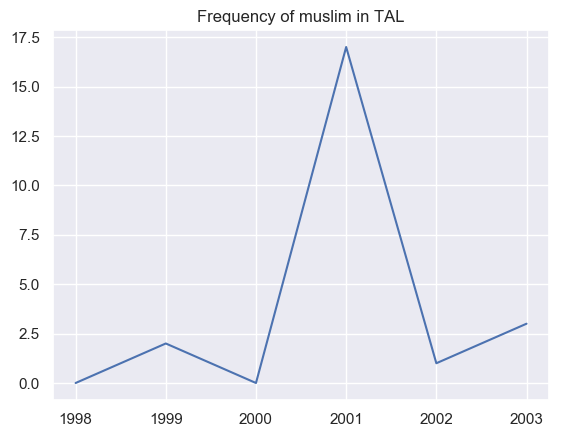

In [484]:
# frequency of word
plot_count(tal_df,[1998,1999,2000,2001,2002,2003],'muslim')

In [ ]:
plot_count(tal_df,[1998,1999,2000,2001,2002,2003],'fear')

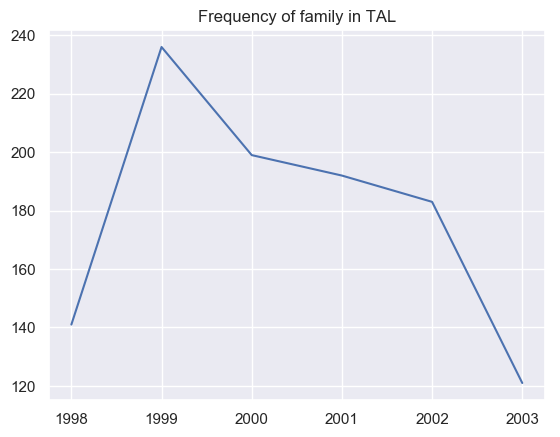

In [422]:
plot_count(tal_df,[1998,1999,2000,2001,2002,2003],'family')

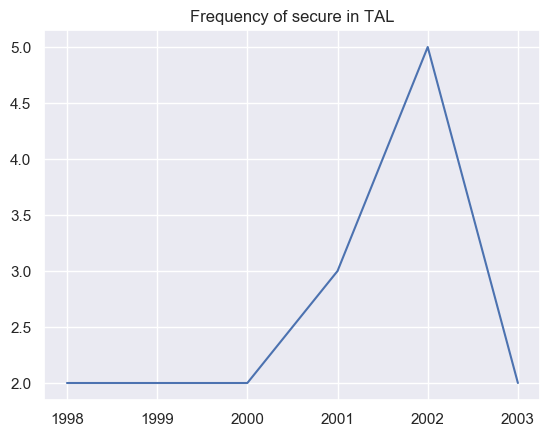

In [425]:
plot_count(tal_df,[1998,1999,2000,2001,2002,2003],'secure')

## Word networks

In [7]:
import networkx as nx

In [57]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g
    
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
        
def graph_nx_word(df, colname, edge_weight, word):
    g = wordCooccurrence(df[colname].sum())
    g.remove_edges_from([(n1, n2) for n1, n2, d in 
                     g.edges(data = True) if d['weight'] <= edge_weight])

    g.remove_nodes_from(list(nx.isolates(g)))
    giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
    # get neighbors of word
    neighbors = giant.neighbors(word)
    g_word = giant.subgraph(neighbors)
    layout = nx.spring_layout(g_word, weight='weight', iterations= 100, k = .3)
    fig, ax = plt.subplots(figsize = (10,10))
    maxWeight = max((d['weight'] for n1, n2, d in g_word.edges(data = True)))
    minWeight = min((d['weight'] for n1, n2, d in g_word.edges(data = True)))
    nx.draw(g_word, ax = ax, pos = layout, labels = {n:n for n in g_word.nodes()},
            width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_word.edges(data = True)], 
            #width =0.3,
            alpha = 1, 
            font_size = 16,
            font_color = 'xkcd:dark grey',
            edge_color = 'black',
            cmap = plt.get_cmap('plasma'))

/Users/laurenli/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


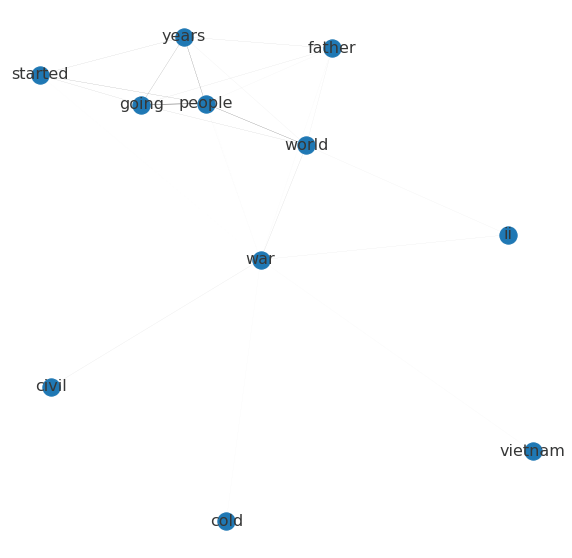

In [58]:
graph_nx_word(grouped, 'no_lemma_normalized_sents', 5, 'war')

In [59]:
grouped2 = tal_df[(tal_df.year==2001) | (tal_df.year==2002) | (tal_df.year==2003)]

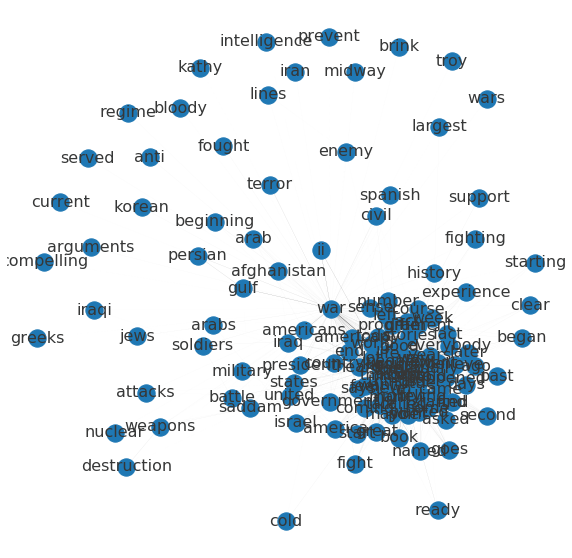

In [60]:
graph_nx_word(grouped2, 'no_lemma_normalized_sents', 5, 'war')

In [5]:
grouped = tal_df[(tal_df.year==1998) | (tal_df.year==1999) | (tal_df.year==2000)]

In [38]:
g = wordCooccurrence(grouped['normalized_sents'].sum())

In [42]:
# change weight, remove less than 25
g.remove_edges_from([(n1, n2) for n1, n2, d in 
                     g.edges(data = True) if d['weight'] <= 5])

g.remove_nodes_from(list(nx.isolates(g)))

In [43]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 2216
Number of edges: 20236
Average degree:  18.2635


In [44]:
# subgraph in sentence cooccurrence
warNeighbors = giant.neighbors('war')
g_war = giant.subgraph(warNeighbors)
print(nx.info(g_war))

Name: 
Type: Graph
Number of nodes: 25
Number of edges: 174
Average degree:  13.9200


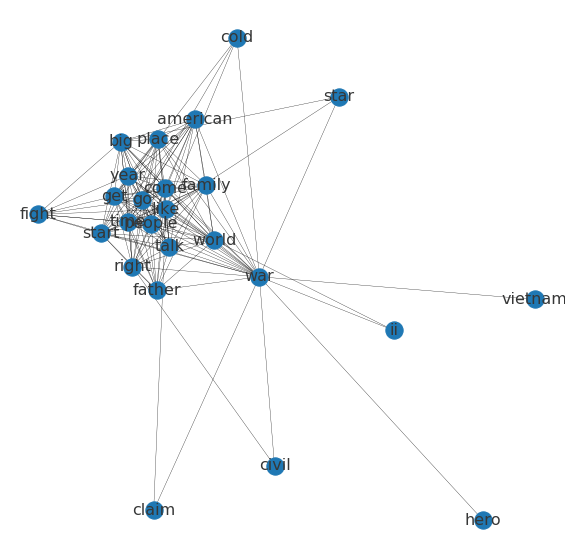

In [53]:
layout_love = nx.spring_layout(g_war, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_war.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_war.edges(data = True)))
nx.draw(g_war, ax = ax, pos = layout_love, labels = {n:n for n in g_war.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_war.edges(data = True)], 
        #width =0.3,
        alpha = 1, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'black',
        cmap = plt.get_cmap('plasma'))

## Word Embeddings

Bias in the embeddings, between two groups with respect to a neutral word list, is quantified by the relative norm
difference, which is calculated as follows: (a) a representative group vector is created as the average of the vectors for
each word in the given gender/ethnicity group; (b) the average l2 norm of the differences between each representative
group vector and each vector in the neutral word list of interest is calculated; (c) the relative norm difference is the
difference of the average l2 norms. This metric captures the relative distance (and thus relative strength of association)
between the group words and the neutral word list of interest.


Negative bias means more associated with the group being subtracted

From: https://arxiv.org/pdf/1711.08412.pdf

In [177]:
grouped = tal_df[(tal_df.year==1998) | (tal_df.year==1999) | (tal_df.year==2000)]

In [183]:
talW2V = gensim.models.word2vec.Word2Vec(grouped['no_lemma_normalized_sents'].sum(),size=1000)

In [224]:
from numpy.linalg import norm

In [226]:
norm(np.array([1,2,3]) - np.array([3,4,5]))

3.4641016151377544

In [313]:
def mk_rep_group_vec(model, wordlist):
    vecs = []
    words = []
    for w in wordlist:
        try:
            v = model[w]
            vecs.append(v)
            words.append(w)
        except KeyError:
            continue
    #print('Caught words: {}'.format(words))
    return np.mean(vecs, axis=0)

def l2_norm_diff(model, rep_vec, wordlist):
    diffs = []
    words = []
    for w in wordlist:
        try:
            v = model[w]
            d = norm(rep_vec - v)
            diffs.append(d)
            words.append(w)
        except KeyError:
            continue
    #print('Caught words: {}'.format(words))
    return np.mean(diffs, axis=0)

def plot_bias(pre_dict, post_dict, title, wordlist_dict):
    diffs = []
    for k,v in wordlist_dict.items():
        tmp = {}
        tmp['category'] = k
        tmp['type'] = 'before event'
        tmp['bias'] = l2_norm_diff(pre_dict['model'], pre_dict['compare_vec'], v) - l2_norm_diff(pre_dict['model'], pre_dict['group_vec'], v)
        diffs.append(tmp)
        tmp = {}
        tmp['category'] = k
        tmp['type'] = 'after event'
        tmp['bias'] = l2_norm_diff(post_dict['model'], post_dict['compare_vec'], v) -l2_norm_diff(post_dict['model'], post_dict['group_vec'], v)
        diffs.append(tmp)
    df = pd.DataFrame(diffs)
    sns.catplot(x="category", y="bias", hue="type", data=df,
                height=6, kind="bar", palette="muted")
    plt.title(title)

In [210]:
# create representative group 
# male
male = ['he', 'son', 'boys', 'boy', 'male', 'man', 'men', 'his', 'nephew', 'nephews', 'brother', 'brothers',
       'father', 'uncle', 'uncles', 'himself']
# female, from the Garg paper
female = ['she', 'daughter', 'hers', 'her', 'mother', 'woman', 'girl', 'herself', 'female', 'females','sister', 'daughters', 'mothers',
          'women', 'girls', 'sisters', 'aunt', 'aunts', 'niece', 'nieces']
# rich
rich = ['rich', 'wealthy', 'wealth', 'expensive', 'affluent', 'affluence', 'afford']
# poor
poor = ['poor', 'cheap', 'poverty', 'broke']
    

In [216]:
male_vec = mk_rep_group_vec(talW2V, male)
female_vec = mk_rep_group_vec(talW2V, female)
rich_vec = mk_rep_group_vec(talW2V, rich)
poor_vec = mk_rep_group_vec(talW2V, poor)

Caught words: ['son', 'boys', 'boy', 'male', 'man', 'men', 'nephew', 'nephews', 'brother', 'brothers', 'father', 'uncle', 'uncles']
Caught words: ['daughter', 'mother', 'woman', 'girl', 'female', 'sister', 'daughters', 'mothers', 'women', 'girls', 'sisters', 'aunt', 'aunts', 'niece', 'nieces']
Caught words: ['rich', 'wealthy', 'wealth', 'expensive']
Caught words: ['poor', 'cheap', 'poverty', 'broke']


In [271]:
talW2V.most_similar('sad')

[('confused', 0.9999450445175171),
 ('claim', 0.9999367594718933),
 ('battle', 0.9999347925186157),
 ('rule', 0.9999343156814575),
 ('ball', 0.9999306797981262),
 ('hanging', 0.9999247789382935),
 ('losing', 0.9999245405197144),
 ('travel', 0.9999228715896606),
 ('pet', 0.9999198913574219),
 ('joke', 0.9999198317527771)]

In [480]:
# neutral word list (war? liberal, conservative)
liberal = ['liberal', 'progressive', 'democrat'] 
conservative = ['conservative','republican', '']
war = ['war', 'soldier', 'soldiers', 'fight', 'battle', 'battles', 'weapon', 'weapons', 'bomb', 'bombs', 'death']
anger = ['angry', 'mad', 'hate', 'anger', 'disgust']
fear = ['scared', 'fear', 'scary', 'afraid']
happy = ['happy', 'excited', 'enjoy', 'enjoying']
sad = ['sad', 'unhappy', 'tears']

In [465]:
# now try on post 9/11
grouped2 = tal_df[(tal_df.year==2001) | (tal_df.year==2002) | (tal_df.year==2003)]

talW2V01 = gensim.models.word2vec.Word2Vec(grouped2['no_lemma_normalized_sents'].sum(),size=1000)

male_vec01 = mk_rep_group_vec(talW2V01, male)
female_vec01 = mk_rep_group_vec(talW2V01, female)
rich_vec01 = mk_rep_group_vec(talW2V01, rich)
poor_vec01 = mk_rep_group_vec(talW2V01, poor)

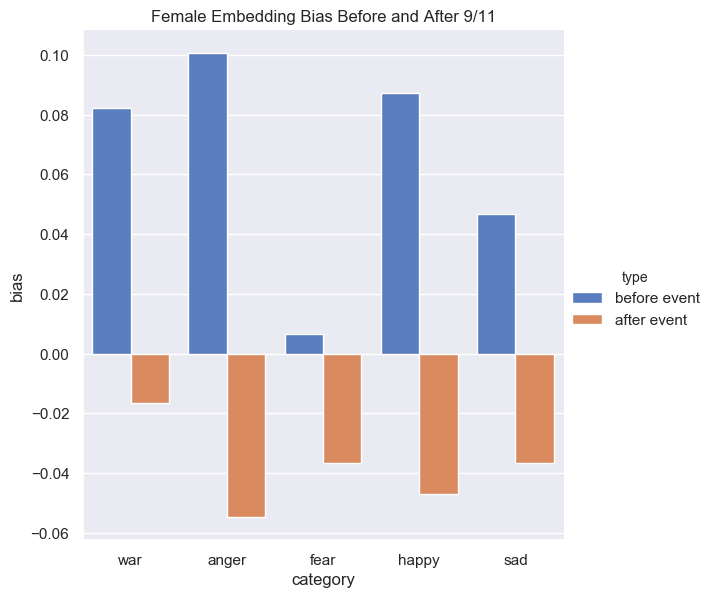

In [481]:
wordlist_dict = {'war': war, 'anger': anger, 'fear': fear, 'happy': happy, 'sad': sad}
pre_dict = {'model': talW2V, 'group_vec': female_vec, 'compare_vec': male_vec}
post_dict = {'model': talW2V01, 'group_vec': female_vec01, 'compare_vec': male_vec01}

plot_bias(pre_dict, post_dict, 'Female Embedding Bias Before and After 9/11',wordlist_dict)

## Most similar words

2001

In [501]:
def agg_sim_words(models,periods,wordlist):
    final = []
    for model in models:
        tmp = {}
        for w in wordlist:
            try:
                x = model.most_similar(w)
                tmp[w] = x
            except KeyError:
                tmp[w] = 'NA'
        final.append(tmp)
        
    new = pd.DataFrame(final)
    new['period'] = periods
    return new

In [502]:
word_all = word1+word2

In [503]:
agg_sim_words([talW2V, talW2V01], ['before 911', 'after 911'], word_all).to_csv('most_sim_9_11.csv', index=False)

In [170]:
# Plotting dimensions as in hw7

In [433]:
# dimensions
Gender = helper.dimension(talW2V, ['man','guy', 'male'], ['woman', 'girl', 'female'])
Race = helper.dimension(talW2V, ['black','blacks', 'brown', ], ['white', 'whites', 'white', 'white'])
Class = helper.dimension(talW2V, ['rich', 'expensive', 'wealthy'], ['poor', 'cheap', 'poor'])

Morality = helper.dimension(talW2V, ['good', 'good', 'honest','pure'], 
                     ['bad', 'evil','lie','dirty'])

Education = helper.dimension(talW2V, ['educated','smart'], 
                      ['dumb','stupid'])
dim_dict = {'gender': Gender, 'race': Race, 'class': Class, 'morality':Morality, 'education':Education}

In [457]:
# word lists
emotions = ['happy', 'sad', 'excited','fear', 'lonely', 'ashamed', 'shame', 
            'embarrassed', 'hate', 'love', 'anger', 'upset', 'tired', 'lazy', 'dread', 'hope']

opinions = ['believe', 'belief', 'perspective', 'opinion', 'thought', 'think', 'attitude']

self=['self', 'appearance', 'looks', 'confidence', 'perception', 'gay', 
      'lesbian', 'black', 'white', 'american', 'exotic']

rel=['single', 'divorce', 'divorced', 'family', 'brother', 'sister', 'children', 'aunt', 'uncle',
     'child', 'wedding', 'married', 'marriage', 'boyfriend', 'girlfriend', 'partner', 'love']



In [458]:
def makeDF(model, word_list, dim_dict):
    new_dict = {}
    for k,v in dim_dict.items():
        tmp = []
        for word in word_list:
            tmp.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), v.reshape(1,-1))[0][0])
        new_dict[k] = tmp
    df = pd.DataFrame(new_dict, index = word_list)
    return df

In [471]:
Emodf = makeDF(talW2V, emotions, dim_dict)
Opdf = makeDF(talW2V, opinions, dim_dict)
Selfdf = makeDF(talW2V, self, dim_dict)
Reldf = makeDF(talW2V, rel, dim_dict)

In [461]:
import matplotlib.pyplot as plt
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Emotions


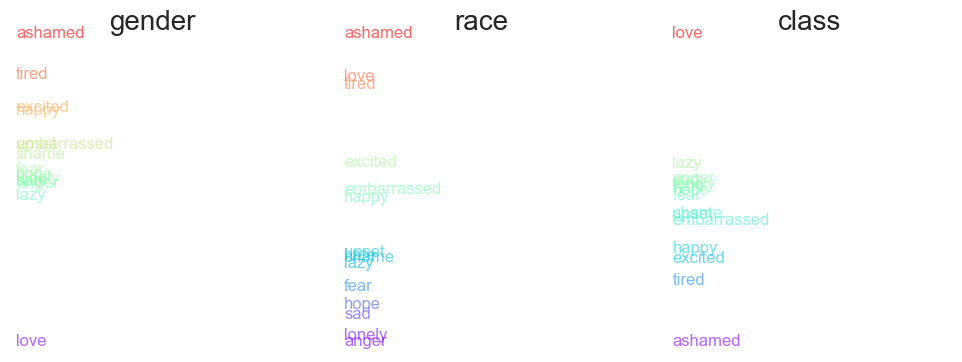

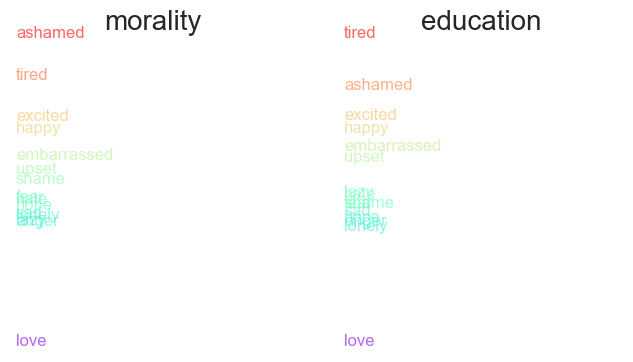

In [472]:

print('Emotions')
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Emodf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Emodf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Emodf, 'class')
plt.show()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Emodf, 'morality')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Emodf, 'education')
plt.show()

In [476]:
## now will 2001-2003

# dimensions
Gender01 = helper.dimension(talW2V01, ['man','guy', 'male','brother','father', 'son'], 
                            ['woman', 'girl', 'female','sister', 'mother','daughter'])
Race01 = helper.dimension(talW2V01, ['black','blacks', 'brown', ], ['white', 'whites', 'white', 'white'])
Class01 = helper.dimension(talW2V01, ['rich', 'expensive', 'wealthy'], ['poor', 'cheap', 'poor'])

Morality01 = helper.dimension(talW2V01, ['good', 'good', 'honest','pure'], 
                     ['bad', 'evil','lie','dirty'])

Education01 = helper.dimension(talW2V01, ['educated','smart'], 
                      ['dumb','stupid'])
dim_dict01 = {'gender': Gender01, 'race': Race01, 'class': Class01, 'morality':Morality01, 'education':Education01}

Emotions


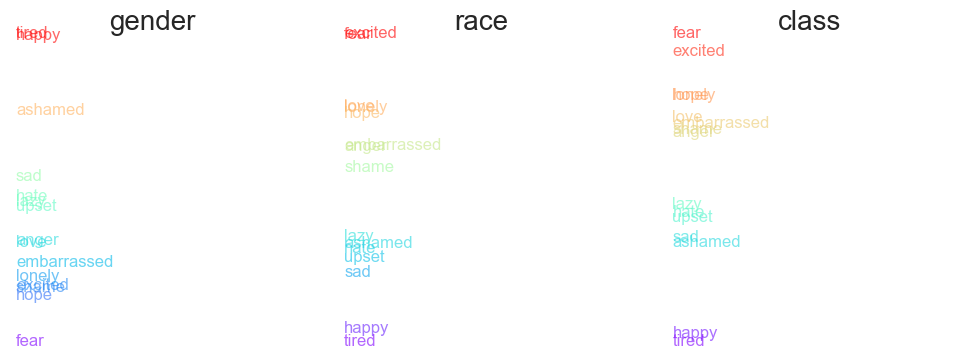

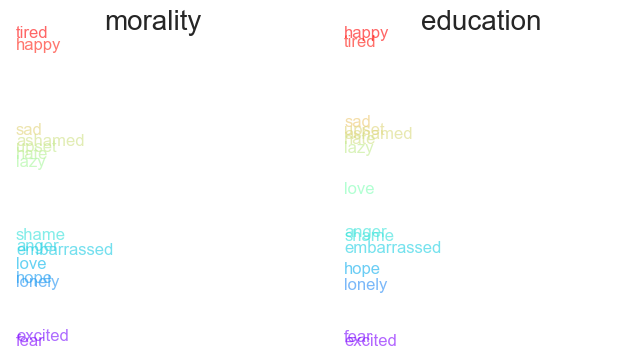

In [477]:
# now will 2001-2003
emotions = ['happy', 'sad', 'excited','fear', 'lonely', 'ashamed', 'shame', 
            'embarrassed', 'hate', 'love', 'anger', 'upset', 'tired', 'lazy', 'hope']
Emodf = makeDF(talW2V01, emotions, dim_dict01)
Opdf = makeDF(talW2V01, opinions, dim_dict01)
Selfdf = makeDF(talW2V01, self, dim_dict01)
Reldf = makeDF(talW2V01, rel, dim_dict01)


print('Emotions')
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Emodf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Emodf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Emodf, 'class')
plt.show()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Emodf, 'morality')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Emodf, 'education')
plt.show()